### Brown, Medina, Vaaga, Holla and Raman -
### Code to generate synaptic currents and spiking traces from the manuscript
Code by Christopher Vaaga (2022)

This file contains the necessary code to generate the synaptic currents and spiking traces from the model presented in Figure 8. 

In [1]:
#Import the relevant packages:
import time
import os 
from neuron import h
from neuron.units import ms, mV
import neuron
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from tabulate import tabulate

#change directory to access routine for creating Purkinje cell 
os.chdir(r'C:\Users\chris\OneDrive - Northwestern University\Documents\Neuron Simulations\Brown_Medina Model')
h.load_file('stdrun.hoc')

1.0

In [2]:
#If the program returns an error about valid density mechanism names, then the dll file is not properly loaded. If that is 
#the case, reload the dll file with the following command. 

#In the case that the dll is correctly loaded, this command will throw an error, so it is commented out by default


#Ensure dll is loaded correctly, to prevent errors in loading density mechanism names
#h.nrn_load_dll(r"C:\Users\chris\OneDrive - Northwestern University\Documents\Neuron Simulations\Brown_Medina Model\nrnmech.dll")

In [3]:
random.seed()

class Pkj:
    def __init__(self, gid):
        self.gid = gid #identifier to allow for creation of multiple cells with soma/dend
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        #create a soma appended to ballandstick cell
        self.soma = h.Section(name = 'soma', cell = self) 
        #create a dendrite section appended to ball and stick cell
        self.dend = h.Section(name = 'dend', cell = self) 
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma) #connect the dendrite to the soma   
        self.soma.L = self.soma.diam = 20 #creates a soma with an area of 500 um2
        self.dend.L = 300
        self.dend.diam = 2.2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 35.4 #set the axial resistance of all sections to 100 Ohm * cm
            sec.cm = 1 #set the membrane capacitance to 1 microFarads / cm^2
        #Insert appropriate currents in soma
        self.soma.insert('kpkj2') #access current with     kpkj2._ref_ik_fast
        self.soma.insert('kpkj') #access current with      kpkj._ref_ik_fast
        self.soma.insert('naRsg') #access current with     naRsg._ref_ina
        self.soma.insert('lkpkj') 
        self.soma.insert('cadiff') 
        self.soma.insert('bkpkj') #access current with     bkpkj._ref_ik_bk
        self.soma.insert('cap') #access current with       cap._ref_ica
        self.soma.insert('hpkj') #not working...
        self.soma.insert('kpkjslow') #access current with  kpkjslow._ref_ik_slow
        self.soma.insert('extracellular')
        
        #Insert appropriate currents in dendrite
        self.dend.insert('kpkj2') #access current with      kpkj2._ref_ik_fast
        self.dend.insert('kpkj') #access current with       kpkj._ref_ik_fast
        self.dend.insert('lkpkj') 
        self.dend.insert('cadiff') 
        self.dend.insert('cap') #access current with        cap._ref_ica
        self.dend.insert('hpkj') 
        self.dend.insert('kpkjslow') #access current with   kpkjslow._ref_ik_slow
        
        #Set appropriate ENa and EK values
        self.soma.ena = 60
        self.soma.ek = -88
        
        #Increase the total sodium conductance from 0.015 S/cm^2 to 0.025 S/cm^2 to account for increased
        #sodium conductances in adults.
        self.soma.gbar_naRsg = 0.025

        self.dend.nseg = 31

        
        #Set up appropraite vectors to record spiking in Purkinje cells
        
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        
        #Set vector to record soma voltage
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)
        
    def __repr__(self):
        return 'Pkj[{}]'.format(self.gid) #reformats name to allow for easy referencing

In [4]:
#Spontaneous Inputs:
#Number of spontaneously active Parallel Fibers and MLI (sc)
n_pf = 1000
n_sc = 5


#MLI Inhibition - calculate conductance from G = I(Vm-Vrev), values of I from He et al., 2015
sc_I_avg = 200 #Current in pA
sc_I_std = 100 #StDev of current in pA

sc_g = (sc_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6
sc_g_std = (sc_I_std * 10 **-12)/(70 * 10 **-3) * 10**6


sc = {'Conductance (mS)':sc_g * 1.3, #scale factor to account for clamp issues observed 
           'Conductance StDev (mS)':sc_g_std * 1.3, #scale factor to account for clamp issues observed
           'Spon Freq (Hz)':20, 
           'Spon Freq StDev (Hz)':10, 
           'Rise Time (ms)': 1.5 * 0.85, #Scale factor to account for dendritic filtering
           'Decay Time (ms)':8 * 0.85, #Scale factor to account for dendritic filtering
           'Reversal Potential (mV)': -70,
          }

#PF excitation - calculate conductance from G = I(Vm-Vrev), values of I from Isope and Barbour, 2002
pf_I_avg = 9 #Current in pA
pf_I_std = 7 #StDev of current in pA

pf_g = (pf_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6
pf_g_std = (pf_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6

pf = {'Conductance (mS)':pf_g , 
           'Conductance StDev (mS)':pf_g_std,
           'Spon Freq (Hz)':0.8, 
           'Spon Freq StDev (Hz)':0.5, 
           'Rise Time (ms)': 1 * 0.9, #Scale factor to accnount for dendritic filtering
           'Decay Time (ms)':14 * 0.9, #Scale factor to account for dendritic filtering
           'Reversal Potential (mV)': 0,
          }

syn_delay = 1.5



#Create a large parallel fiber amplitude distribution with PF amplitude values derived from Isope and Barbour, 2002.
#Because this distribution contains negative conductance values, these values are removed and the distribution is scaled
#to maintain the mean PF amplitude after removing negative events.

#create large distribution of conductances
pf_adjusted_dist = np.random.normal(pf['Conductance (mS)'], pf['Conductance StDev (mS)'],10000) 
#filter out any negative values
pf_adjusted_dist = list(filter(lambda x: (x > 0), pf_adjusted_dist)) 
#calculate the adjustment factor to restore mean to mean conductance from literature
pf_adj = pf['Conductance (mS)'] / np.mean(pf_adjusted_dist) 
#adjust filtered distribution to recenter values at mean conductance from literature 
pf_adjusted_dist = np.array(pf_adjusted_dist) * pf_adj 



#Create a large MLI amplitude distribution with amplitude values derived from He et al., 2015.
#Because this distribution contains negative conductance values, these values are removed and the distribution is scaled
#to maintain the mean MLI amplitude after removing negative events.

#create large distribution of conductances
mli_adjusted_dist = np.random.normal(sc['Conductance (mS)'], sc['Conductance StDev (mS)'], 10000)
#filter out any negative values
mli_adjusted_dist = list(filter(lambda x: (x > 0), mli_adjusted_dist)) 
#calculate the adjustment factor to restore mean to mean conductance from literature 
mli_adj = sc['Conductance (mS)'] / np.mean(mli_adjusted_dist) 
#adjust filtered distribution to recenter values at mean conductance from literature 
mli_adjusted_dist = np.array(mli_adjusted_dist) * mli_adj 

### Parallel Fiber EPSC

In [5]:
#%% Model parallel fiber EPSC in voltage clamp (100 trials)
pkj1 = Pkj(1)

#EPSC model - 100 trials for amplitude test
current_trials_epsc = np.empty((100,4001))
for i in range(100):
    
    vc = h.SEClamp(pkj1.soma(0.5))
    vc.amp1 = -70
    vc.dur1 = 100

    pf_synapse = h.Exp2Syn(pkj1.dend(np.random.randint(0,1000)/1000))
    pf_synapse.tau1 = pf['Rise Time (ms)']
    pf_synapse.tau2 = pf['Decay Time (ms)']
    pf_synapse.e = pf['Reversal Potential (mV)']

    ns = h.NetStim()
    ns.number = 1
    ns.start = 20

    nc = h.NetCon(ns,pf_synapse)
    pf_conductance = np.random.normal(pf['Conductance (mS)'],pf['Conductance StDev (mS)'])
    nc.weight[0] = np.random.choice(pf_adjusted_dist)

    t = h.Vector().record(h._ref_t)
    current = h.Vector().record(pf_synapse._ref_i)
    
    

    h.finitialize(-70)
    h.continuerun(vc.dur1)

    current = np.array([current])
    current *= 1000
    current_trials_epsc[i,:] = current
    
t_vc = np.array(t)
t_vc = np.subtract(t,10)


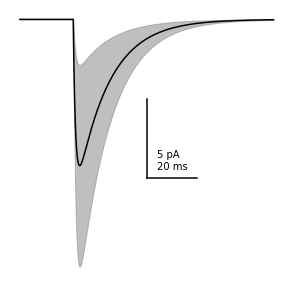

In [12]:
i_epsc = np.mean(current_trials_epsc,axis = 0)
i_epsc_std = np.std(current_trials_epsc,axis = 0)

i_epsc_amplitude = np.zeros(100)
for i in range(len(i_epsc_amplitude)):
    i_epsc_amplitude[i] = np.min(current_trials_epsc[i,:])

i_epsc_avg_amplitude = np.mean(i_epsc_amplitude)
i_epsc_std_amplitude = np.std(i_epsc_amplitude) 

epsc_data = np.array([t_vc, i_epsc, i_epsc_std])


fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111)
plt.plot(epsc_data[0], epsc_data[1], color = 'black')
plt.fill_between(epsc_data[0], epsc_data[1] + epsc_data[2], epsc_data[1] - epsc_data[2], color = 'grey', alpha = 0.5)
x_scale = [40, 60]
y_scale = [-10, -5]
plt.plot([x_scale[0], x_scale[0]], [y_scale[0], y_scale[1]], color = 'black')
plt.plot([x_scale[0], x_scale[1]], [y_scale[0], y_scale[0]], color = 'black')
plt.text(x_scale[0]*1.1, y_scale[0] + 0.5, '20 ms')
plt.text(x_scale[0]*1.1, y_scale[0] + 1.25, '5 pA')
plt.yticks([])
plt.xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


### MLI IPSC

In [7]:
current_trials_ipsc = np.empty((100,4001))
for i in range(100):
    
    vc = h.SEClamp(pkj1.soma(0.5))
    vc.amp1 = 0
    vc.dur1 = 100

    sc_synapse = h.Exp2Syn(pkj1.dend(np.random.randint(0,1000)/1000))
    sc_synapse.tau1 = sc['Rise Time (ms)']
    sc_synapse.tau2 = sc['Decay Time (ms)']
    sc_synapse.e = sc['Reversal Potential (mV)']

    ns = h.NetStim()
    ns.number = 1
    ns.start = 20
    
    nc = h.NetCon(ns,sc_synapse)
    sc_conductance = np.random.normal(sc['Conductance (mS)'],sc['Conductance StDev (mS)']) 
    nc.weight[0] = np.random.choice(mli_adjusted_dist)

    t = h.Vector().record(h._ref_t)
    current = h.Vector().record(sc_synapse._ref_i)


    h.finitialize(0)
    h.continuerun(vc.dur1)

    current = np.array(current)
    current *= 1000
    
    current_trials_ipsc[i,:] = current

t_vc = np.array(t)
t_vc = np.subtract(t,10)

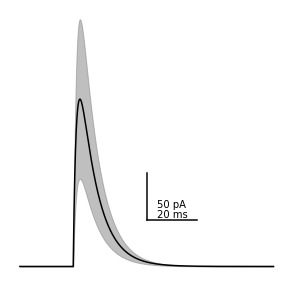

In [13]:
i_ipsc = np.mean(current_trials_ipsc,axis = 0)
i_ipsc_std = np.std(current_trials_ipsc,axis = 0)

i_ipsc_amplitude = np.zeros(100)
for i in range(len(i_ipsc_amplitude)):
    i_ipsc_amplitude[i] = np.max(current_trials_ipsc[i,:])

i_ipsc_avg_amplitude = np.mean(i_ipsc_amplitude)
i_ipsc_std_amplitude = np.std(i_ipsc_amplitude) 


ipsc_data = np.array([t_vc, i_ipsc, i_ipsc_std])

fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111)
plt.plot(ipsc_data[0], ipsc_data[1], color = 'black')
plt.fill_between(ipsc_data[0], ipsc_data[1] + ipsc_data[2], ipsc_data[1] - ipsc_data[2], color = 'grey', alpha = 0.5)
x_scale = [40, 60]
y_scale = [50, 100]
plt.plot([x_scale[0], x_scale[0]], [y_scale[0], y_scale[1]], color = 'black')
plt.plot([x_scale[0], x_scale[1]], [y_scale[0], y_scale[0]], color = 'black')
plt.text(x_scale[0]*1.1, y_scale[0] + 2, '20 ms')
plt.text(x_scale[0]*1.1, y_scale[0] + 12, '50 pA')
plt.yticks([])
plt.xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


### Spontaneous firing rate with PF/MLI inputs

In [19]:
pkj2 = Pkj(1)

synapse_pf_spon = [] #Set up empty array for synapse properties
stim_pf = [] #set up list for pf netstim objects
nc_pf = [] #empty array for netcon objects



synapse_mli_spon = [] #Set up empty array for synapse properties
stim_mli_spon = [] #set up list for pf netstim objects
nc_mli_spon = [] #empty array for netcon objects

n_pf = 1500 #Number of spontaneous pf inputs (each firing at ~ 1 Hz)
n_mli = 5 #Number of spontaneous mli inputs (each firing at ~ 20 Hz)

#Set up tmp vectors for recording input times from pf and mli inputs
tmp_pf = h.Vector()
tmp_mli = h.Vector()
t_pf = h.Vector()
t_mli = h.Vector()

for k in range(n_pf): 
        synapse_pf_spon.append(h.Exp2Syn(pkj2.dend(np.random.randint(0,1000)/1000)))
        synapse_pf_spon[-1].tau1 = pf['Rise Time (ms)']
        synapse_pf_spon[-1].tau2 = pf['Decay Time (ms)']
        synapse_pf_spon[-1].e = pf['Reversal Potential (mV)']
        
        stim_pf.append(h.NetStim()) #append new netstim to netstim list
        stim_pf[-1].number = 200 #set number of pf events to generate
        stim_pf[-1].start = np.random.exponential(100) #randomly distribute start times to increase "noise" in the system"
        freq_tmp = np.random.uniform(0.7, 0.9)
        
        #np.random.normal(pf['Spon Freq (Hz)'],pf['Spon Freq StDev (Hz)']) #Set each PF input to have a specific average firing rate (normally distributed)
        #if freq_tmp < 0: freq_tmp = pf['Spon Freq (Hz)']
        stim_pf[-1].interval = 1000/freq_tmp
        stim_pf[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)

        nc_pf.append(h.NetCon(stim_pf[-1],synapse_pf_spon[-1])) #append NetStim[i] to syn_mli mechanism defined in pkj class
        pf_conductance = np.random.normal(pf['Conductance (mS)'],pf['Conductance StDev (mS)']) 
        if pf_conductance < 0: #Correct for events that are outward - if event chosen is negative set to the mean
            pf_conductance = pf['Conductance (mS)']
        nc_pf[-1].weight[0] = pf_conductance #set synaptic weight by dividing amplitude by netcon scale factor
        nc_pf[-1].record(tmp_pf)
        
for j in range(n_mli): 
        synapse_mli_spon.append(h.Exp2Syn(pkj2.dend(np.random.randint(0,1000)/1000)))
        synapse_mli_spon[-1].tau1 = sc['Rise Time (ms)']
        synapse_mli_spon[-1].tau2 = sc['Decay Time (ms)']
        synapse_mli_spon[-1].e = sc['Reversal Potential (mV)']
        
        stim_mli_spon.append(h.NetStim()) #append new netstim to netstim list
        stim_mli_spon[-1].number = 200
        stim_mli_spon[-1].start = np.random.exponential(100) #randomly distribute start times to increase "noise" in the system" #randomly distribute start times to increase "noise" in the system"
        frq_tmp = np.random.normal(sc['Spon Freq (Hz)'], sc['Spon Freq StDev (Hz)'])
        stim_mli_spon[-1].interval = 1000/frq_tmp
        stim_mli_spon[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)

        nc_mli_spon.append(h.NetCon(stim_mli_spon[-1],synapse_mli_spon[-1]))  #append NetStim[i] to syn_pf mechanism defined in pkj class
        mli_conductance = np.random.normal(sc['Conductance (mS)'],sc['Conductance StDev (mS)']) #Select pf amplitude (Gaussian distribution) 
        if mli_conductance < 0: #Correct for events that are inward - if event chosen is negative set to the mean
            mli_conductance = sc['Conductance (mS)']
        nc_mli_spon[-1].weight[0] = mli_conductance
        nc_mli_spon[-1].record(tmp_mli)


t = h.Vector().record(h._ref_t)

pkj_raster = h.Vector() #Create a raster vector
nc_target_pkj = h.NetCon(pkj2.soma(0.5)._ref_v, None, sec = pkj2.soma) #Netcon with empty target to detect when events are generated in soma
nc_target_pkj.threshold = -10 #Set threshold for event detection
nc_target_pkj.record(pkj_raster) #Records the timing events into pkj_raster vector

h.finitialize()
h.continuerun(1000)

t_pf.append(tmp_pf)
t_mli.append(tmp_mli)
t_pf = np.array(t_pf)
t_mli = np.array(t_mli)

#%% Analysis on spike frequency
#Collect spike times as a numpy array
spike_times = np.array(pkj_raster)
#calculate the instantaneous frequencies
freq = np.zeros(len(spike_times)-1)
for k in range(1,len(spike_times)): freq[k-1] = 1000 / (spike_times[k]-spike_times[k-1]) #Calculate the instantaneous firing frequency
freq_avg_inputs = np.mean(freq) #Calculate mean firing freqency by converting mean ISI (in ms) to frequency
freq_std_inputs = np.std(freq)

print('\n')
print('Spontaneous Firing Rate (1000 PF, 5 MLI): ', np.round(freq_avg_inputs,1), '+/-', round(freq_std_inputs,1), ' Spikes/sec')

t = np.array(t)
t = np.subtract(t,200)



Spontaneous Firing Rate (1000 PF, 5 MLI):  92.4 +/- 14.0  Spikes/sec


<Figure size 432x288 with 0 Axes>

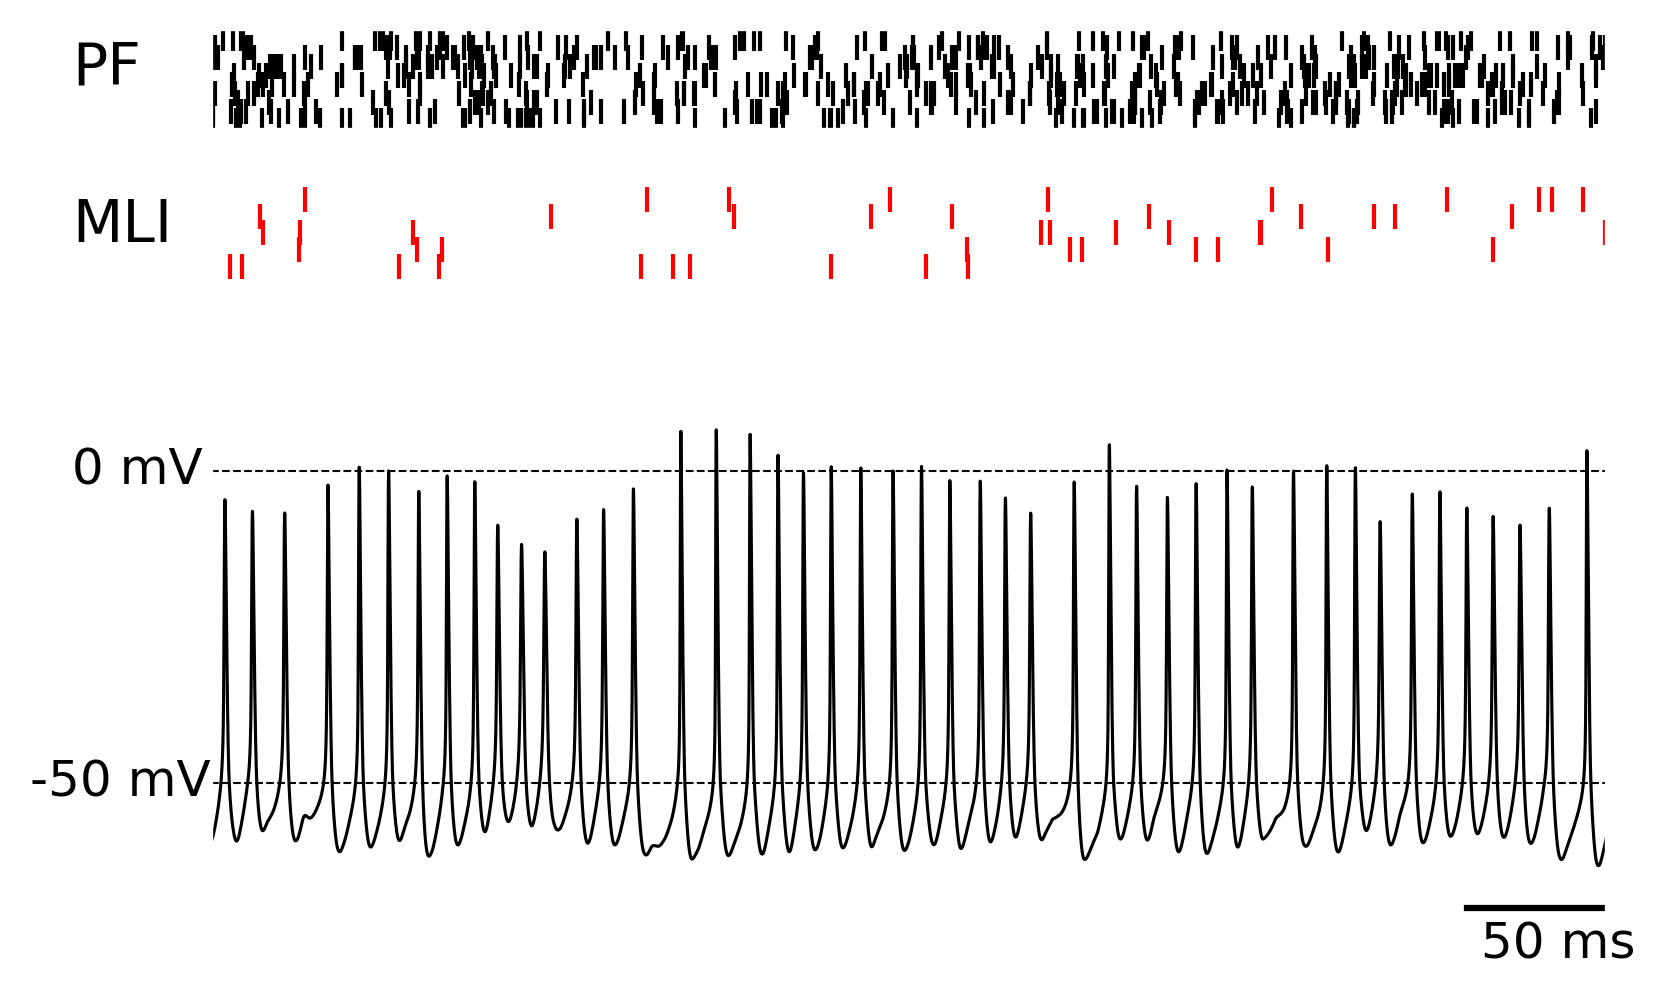

In [20]:
#for displaying purposes - remove any parallel fiber/sc inputs that occur before 200 ms (subtracted time)
t_pf_filtered = np.array(list(filter(lambda x: (x > 200), t_pf)))
t_pf_filtered = np.array(list(filter(lambda x: (x < 700), t_pf_filtered)))
t_mli_filtered = np.array(list(filter(lambda x: (x > 200), t_mli)))
t_mli_filtered = np.array(list(filter(lambda x: (x < 700), t_mli_filtered)))
t_mli_filtered -= 200
t_pf_filtered -= 200

np.random.shuffle(t_pf_filtered)
np.random.shuffle(t_mli_filtered)

t_pf_shuffle = np.array_split(t_pf_filtered, 10)
t_mli_shuffle = np.array_split(t_mli_filtered, 5)

plt.figure(3)
heights = [0.5, 0.5, 3]
fig, (ax1, ax2, ax3) = plt.subplots(3,1, gridspec_kw = {'height_ratios':heights}, dpi = 300)

for i in range(10):
    x_array = np.ones(len(t_pf_shuffle[i]))
    x_array += i
    ax1.plot(t_pf_shuffle[i],x_array,'|',color = 'black')
for i in range(5):
    x_array = np.ones(len(t_mli_shuffle[i]))
    x_array += i
    ax2.plot(t_mli_shuffle[i], x_array, '|', color = 'red')

ax3.plot(t,pkj2.soma_v, color = 'black', linewidth = 0.75)
ax1.set_ylim([0,11])
ax1.text(-50, 5, 'PF', fontsize = 14)

ax1.set_yticks([])
ax1.set_xticks([])
ax2.set_ylim([0,6])

ax2.text(-50, 2.5, 'MLI', fontsize = 14)
ax2.set_yticks([])
ax2.set_xticks([])
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')

ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['left'].set_color('white')

ax1.set_xlim(0,500)
ax2.set_xlim(0,500)
ax3.set_xlim(0,500)
ax3.plot([450,500], [-70,-70], color = 'black')
ax3.text(455, -78, '50 ms', fontsize = 12)
ax3.axhline(0, color = 'black', linewidth = 0.5, linestyle = '--')
ax3.text(-50, -2, '0 mV', fontsize = 12)
ax3.axhline(-50, color = 'black', linewidth = 0.5, linestyle = '--')
ax3.text(-65, -52, '-50 mV', fontsize = 12)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.spines['bottom'].set_color('white')
ax3.spines['top'].set_color('white')
ax3.spines['right'].set_color('white')
ax3.spines['left'].set_color('white')


### Family of E-I Traces with variable GPF

In [21]:
pf_scale_factor = [0, 2, 4, 6]
n_stim = 1
pf_start = 200
mli_syn_delay = 1.5

current_family_avg = np.empty(((len(pf_scale_factor), 10001)))
time_family_avg = np.empty(((len(pf_scale_factor), 10001)))
current_family = np.empty((10,10001))
time_family = np.empty((10,10001))
for i in range(len(pf_scale_factor)):
    for k in range(10):

        pkj3 = Pkj(3)
        h.load_file('stdrun.hoc')
        
        vc = h.SEClamp(pkj3.soma(0.5))
        vc.amp1 = -50
        vc.dur1 = 250
        
        #Set up the synapse:
        pf_synapse = h.Exp2Syn(pkj3.dend(np.random.randint(0,1000)/1000))
        pf_synapse.tau1 = pf['Rise Time (ms)']
        pf_synapse.tau2 = pf['Decay Time (ms)']
        pf_synapse.e = pf['Reversal Potential (mV)']
        
        #Set up the NetStim object:
        pf_ns = h.NetStim() #append new netstim to netstim list
        pf_ns.number = 1
        pf_ns.start = pf_start
        
        #Set up the NetCon object:
        pf_nc = h.NetCon(pf_ns,pf_synapse)  
        pf_nc.weight[0] = np.random.choice(pf_adjusted_dist) * pf_scale_factor[i]
        
        
        mli_synapse = h.Exp2Syn(pkj3.dend(np.random.randint(0,1000)/1000))
        mli_synapse.tau1 = sc['Rise Time (ms)']
        mli_synapse.tau2 = sc['Decay Time (ms)']
        mli_synapse.e = sc['Reversal Potential (mV)']
        
        mli_ns = h.NetStim()
        mli_ns.number = 1
        mli_ns.start = pf_start + mli_syn_delay
        
        mli_nc = h.NetCon(mli_ns,mli_synapse)
        mli_nc.weight[0] = np.random.choice(mli_adjusted_dist)
        
        t = h.Vector().record(h._ref_t)
        current = h.Vector().record(vc._ref_i)
        
        h.finitialize(vc.amp1)
        h.continuerun(vc.dur1)
        
        time = np.array(t)
        
        mix_current = current * 1000
        mix_current = np.array(mix_current)
        
        baseline_indx = int(next(x for x, val in enumerate(time) if val > pf_start - 50))
        baseline = np.mean(mix_current[baseline_indx-50:baseline_indx])
        mix_current = mix_current - baseline
        time = time - 200
        
        time_family[k,:] = time
        current_family[k,:] = mix_current
        
    current_family_avg[i,:] = np.mean(current_family, axis = 0)
    time_family_avg[i,:] = np.mean(time_family, axis = 0)

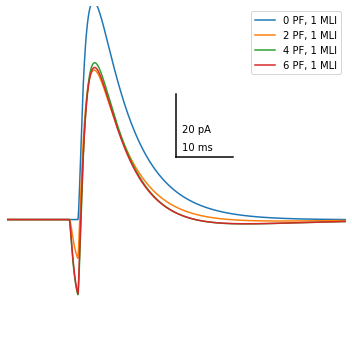

In [25]:
color = np.zeros((len(pf_scale_factor), 4))
for i in range(len(pf_scale_factor)):
    color[i,:] = plt.cm.tab10(i)
labels = ['0 PF, 1 MLI', '2 PF, 1 MLI', '4 PF, 1 MLI', '6 PF, 1 MLI']
    
fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111)
for i in range(len(pf_scale_factor)):
    plt.plot(time_family_avg[i], current_family_avg[i], c = color[i], label = labels[i], )
    plt.xlim(-10,50)
    plt.ylim(-40, 68)
    x_scale = [20,30]
    y_scale = [20, 40]
    if i == 0: 
        plt.plot([x_scale[0], x_scale[0]], [y_scale[0], y_scale[1]], color = 'black')
        plt.plot([x_scale[0], x_scale[1]], [y_scale[0], y_scale[0]], color = 'black')
        plt.text(x_scale[0]*1.05, y_scale[0] + 2, '10 ms')
        plt.text(x_scale[0]*1.05, y_scale[0] + 8, '20 pA')
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()

### Facilitation of PF inputs with constant I

In [ ]:
current_trials_ipsc = np.empty((100,20001))

n_burst = 5
burst_freq = 50
timing_array = np.linspace(200,280, 5)
pf_facilitation = [1, 2.25, 3, 3.5, 4]
pf_difference = np.zeros(len(pf_facilitation))
for i in range(1,len(pf_facilitation)):
    pf_difference[i] = pf_facilitation[i]-pf_facilitation[i-1]
Gmli = 1


for i in range(100):

    #%% Model parallel fiber EPSC in voltage clamp (100 trials)
    pkj = Pkj(1)

    #EPSC model - 100 trials for amplitude test
    vc = h.SEClamp(pkj.soma(0.5))
    vc.amp1 = -50
    vc.dur1 = 500

    synapse_pf_burst = []
    stim_pf_burst = [] 
    nc_pf_burst = []

    synapse_mli_burst = []
    stim_mli_burst = [] 
    nc_mli_burst = []

    for y in range(n_burst):
        #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
        synapse_pf_burst.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
        synapse_pf_burst[-1].tau1 = pf['Rise Time (ms)']
        synapse_pf_burst[-1].tau2 = pf['Decay Time (ms)']
        synapse_pf_burst[-1].e = pf['Reversal Potential (mV)']

        #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
        stim_pf_burst.append(h.NetStim()) #append new netstim to netstim list
        stim_pf_burst[-1].number = n_burst - y #set number of events to generate (more than necessary for full length run)
        stim_pf_burst[-1].start = timing_array[y] #randomly distribute start times to increase "noise" in the system"
        stim_pf_burst[-1].interval = 1000/burst_freq

        #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
        nc_pf_burst.append(h.NetCon(stim_pf_burst[-1],synapse_pf_burst[-1])) 
        pf_amplitudes = np.random.choice(pf_adjusted_dist, 5)
        nc_pf_burst[-1].weight[0] = pf_amplitudes[y] + (pf_amplitudes[y] * pf_difference[y])


    #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
    synapse_mli_burst = h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000))
    synapse_mli_burst.tau1 = sc['Rise Time (ms)']
    synapse_mli_burst.tau2 = sc['Decay Time (ms)']
    synapse_mli_burst.e = sc['Reversal Potential (mV)']

    #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
    stim_mli_burst = h.NetStim() #append new netstim to netstim list
    stim_mli_burst.number = n_burst #set number of events to generate (more than necessary for full length run)
    stim_mli_burst.start = timing_array[0] + syn_delay #randomly distribute start times to increase "noise" in the system"
    stim_mli_burst.interval = 1000/burst_freq

    #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
    nc_mli_burst = h.NetCon(stim_mli_burst,synapse_mli_burst)
    test = np.random.choice(mli_adjusted_dist) 
    nc_mli_burst.weight[0] = np.random.choice(mli_adjusted_dist)

    t = h.Vector().record(h._ref_t)
    current = h.Vector().record(vc._ref_i)

    h.finitialize(vc.amp1)
    h.continuerun(vc.dur1)

    time = np.array(t)
    current = np.array([current])
    current *= 1000


    baseline_indx = int(next(x for x, val in enumerate(time) if val > timing_array[0] - 50))
    baseline = np.mean(current[0][baseline_indx-50:baseline_indx])
    current = current - baseline

    current_trials_ipsc[i,:] = current[0]

t_vc = np.subtract(t,200)


In [ ]:
current_avg = np.mean(current_trials_ipsc, axis = 0)
current_std = np.std(current_trials_ipsc, axis = 0)

fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111)
plt.plot(t_vc, current_avg, color = 'black')
plt.fill_between(t_vc, current_avg + current_std, current_avg - current_std, alpha = 0.5, color = 'grey')
plt.ylim(-60,120)
plt.xlim(-20,120)
x_scale = [100, 120]
y_scale = [50, 75]
plt.plot([x_scale[0], x_scale[0]], [y_scale[0], y_scale[1]], color = 'black')
plt.plot([x_scale[0], x_scale[1]], [y_scale[0], y_scale[0]], color = 'black')
plt.text(x_scale[0]+2, y_scale[0] + 2, '20 ms')
plt.text(x_scale[0]+2, y_scale[0] + 12, '25 pA')
plt.yticks([])
plt.xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
